## Setup

In [3]:
import numpy as np
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import timm
import torch.nn as nn
from torch.optim import Adam

## Preprocessing MRI Data

In [4]:
class MRI_Dataset(Dataset):
    def __init__(self, tumor_dir, healthy_dir):
        self.tumor = [self.load_image(f) for f in glob.glob(tumor_dir)]
        self.healthy = [self.load_image(f) for f in glob.glob(healthy_dir)]
        self.labels = np.concatenate([np.ones(len(self.tumor)), np.zeros(len(self.healthy))])  # 1 for tumor, 0 for healthy
        self.images = np.array(self.tumor + self.healthy)
    
    def load_image(self, path):
        img = cv2.imread(path)
        img = cv2.resize(img, (224, 224))  # Resize to 224x224 for Vision Transformer
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        return img / 255.0  # Normalize to [0, 1]
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return torch.tensor(self.images[idx], dtype=torch.float32).permute(2, 0, 1), torch.tensor(self.labels[idx], dtype=torch.long)

dataset = MRI_Dataset("./yes/*.jpg", "./no/*.jpg")

## Splitting the Data into Training and Validation Sets

In [5]:
# Split the dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

## Defining the Vision Transformer Model

In [6]:
# Vision Transformer model using the 'timm' library
class SimpleViT(nn.Module):
    def __init__(self):
        super(SimpleViT, self).__init__()
        # Load a pre-trained Vision Transformer (ViT)
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.vit.head = nn.Linear(self.vit.head.in_features, 2)  # Modify for binary classification
    
    def forward(self, x):
        return self.vit(x)

model = SimpleViT()

## Training the Model

In [7]:
# Training setup
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = Adam(model.parameters(), lr=1e-4)  # Optimizer

# Variables to track accuracy and loss
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 5  
for epoch in range(num_epochs):
    model.train()  
    total_loss = 0
    correct = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(correct / len(train_loader.dataset))
    print(f"Epoch {epoch+1}, Loss: {train_losses[-1]}, Accuracy: {train_accuracies[-1] * 100:.2f}%")
    
    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            val_correct += (outputs.argmax(1) == labels).sum().item()
    
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / len(val_loader.dataset))
    print(f"Validation Loss: {val_losses[-1]}, Validation Accuracy: {val_accuracies[-1] * 100:.2f}%")


Epoch 1, Loss: 0.8715234971963443, Accuracy: 66.33%
Validation Loss: 0.704694464802742, Validation Accuracy: 67.35%
Epoch 2, Loss: 0.700128083045666, Accuracy: 56.63%
Validation Loss: 0.611006997525692, Validation Accuracy: 63.27%
Epoch 3, Loss: 0.5536300127322857, Accuracy: 69.90%
Validation Loss: 0.5839990302920341, Validation Accuracy: 67.35%
Epoch 4, Loss: 0.5287850063580734, Accuracy: 79.08%
Validation Loss: 0.5340774096548557, Validation Accuracy: 71.43%
Epoch 5, Loss: 0.5190042142684643, Accuracy: 76.53%
Validation Loss: 0.530883613973856, Validation Accuracy: 69.39%


## Evaluating the Model

In [8]:
model.eval()  
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix and accuracy
cm = confusion_matrix(all_labels, all_preds)
accuracy = accuracy_score(all_labels, all_preds)
print(f"Confusion Matrix:\n{cm}")
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Confusion Matrix:
[[12 14]
 [ 1 22]]
Validation Accuracy: 69.39%


# Visualizing Results

### Confusion Matrix

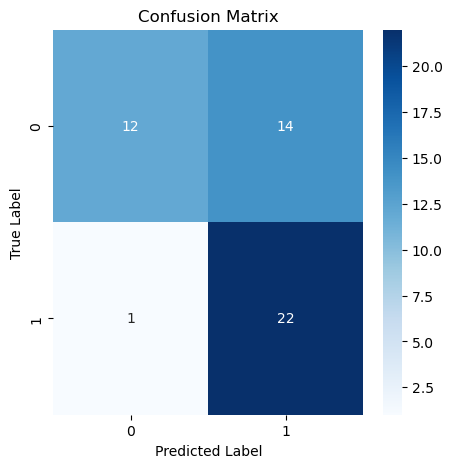

In [9]:
# Plot confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Sample Predictions

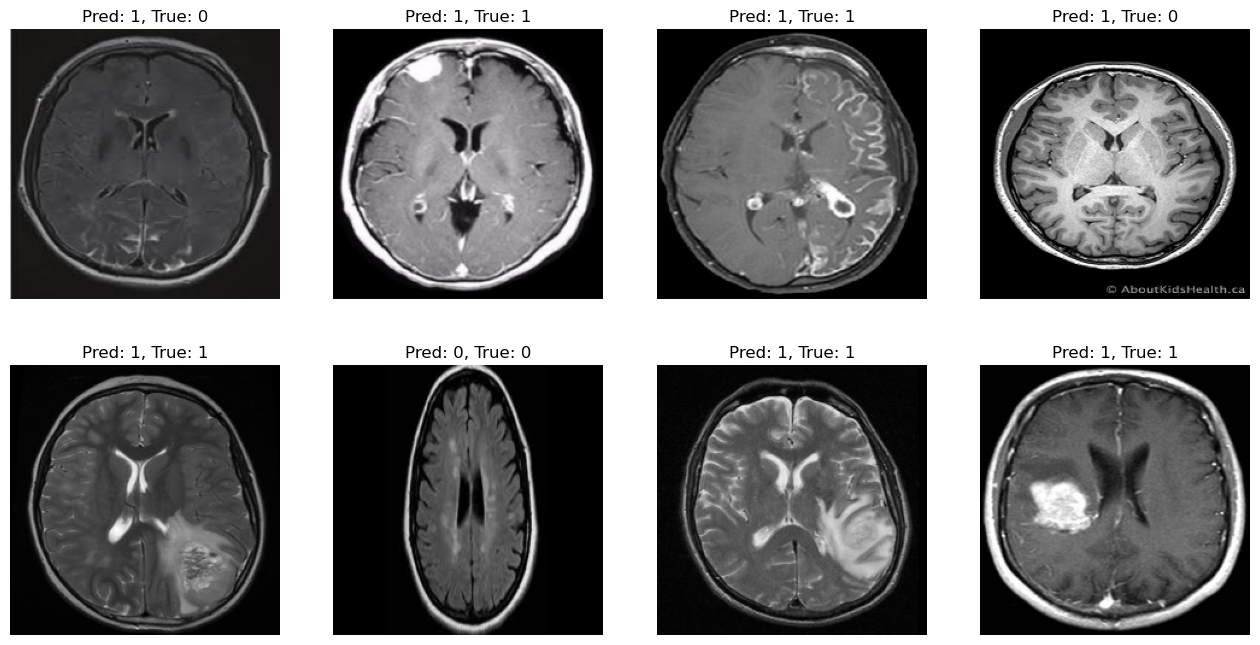

In [10]:
def show_sample_predictions(model, dataset, num_samples=8):
    model.eval()
    fig, axs = plt.subplots(2, num_samples//2, figsize=(16, 8))  # Display in two rows
    for i in range(num_samples):
        img, label = dataset[i]
        with torch.no_grad():
            pred = model(img.unsqueeze(0)).argmax(1).item()
        row = i // (num_samples//2)
        col = i % (num_samples//2)
        axs[row, col].imshow(img.permute(1, 2, 0).cpu().numpy())  # Convert tensor to HxWxC
        axs[row, col].set_title(f'Pred: {pred}, True: {int(label)}')
        axs[row, col].axis('off')
    plt.show()

show_sample_predictions(model, val_dataset)


### Misclassifications

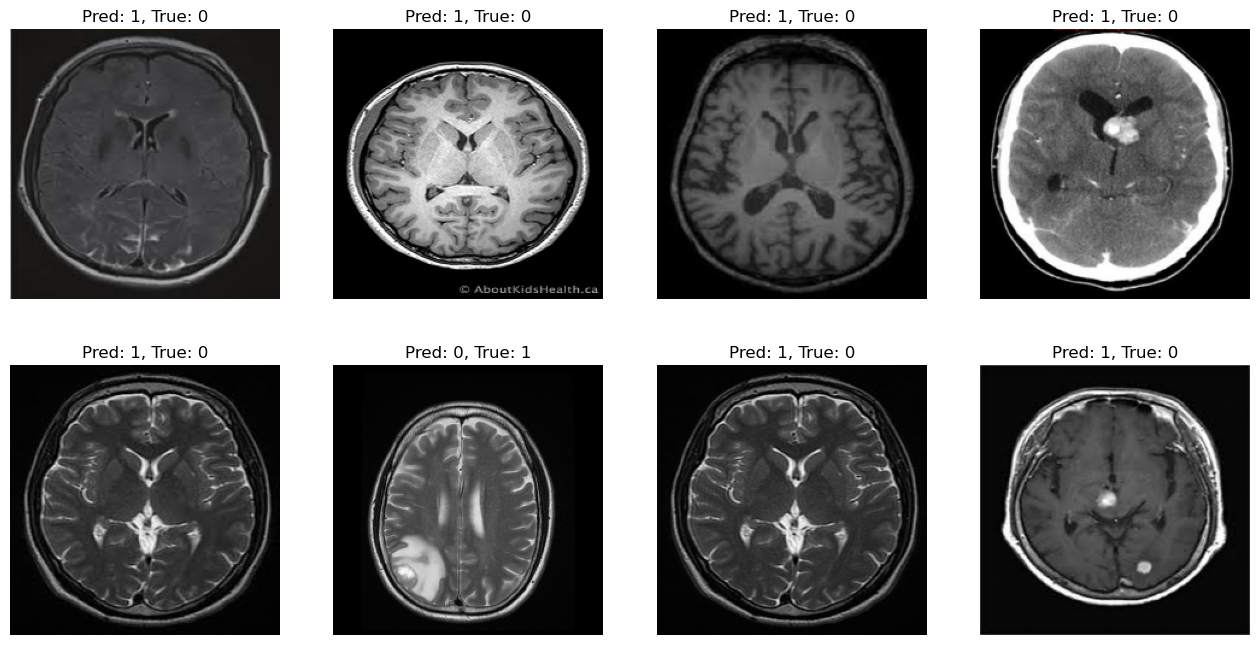

In [11]:
# Visualize misclassified images
def show_misclassifications(model, dataset, num_samples=8):
    model.eval()
    misclassified = []
    for i in range(len(dataset)):
        img, label = dataset[i]
        with torch.no_grad():
            pred = model(img.unsqueeze(0)).argmax(1).item()
        if pred != label:
            misclassified.append((img, label, pred))
        if len(misclassified) == num_samples:
            break

    fig, axs = plt.subplots(2, num_samples//2, figsize=(16, 8))  # Two rows of images
    for i, (img, label, pred) in enumerate(misclassified):
        row = i // (num_samples//2)
        col = i % (num_samples//2)
        axs[row, col].imshow(img.permute(1, 2, 0).cpu().numpy())  # Convert tensor to HxWxC
        axs[row, col].set_title(f'Pred: {pred}, True: {int(label)}')
        axs[row, col].axis('off')
    plt.show()

# Show misclassified images
show_misclassifications(model, val_dataset)


### Visualizing Training and Validation Curves

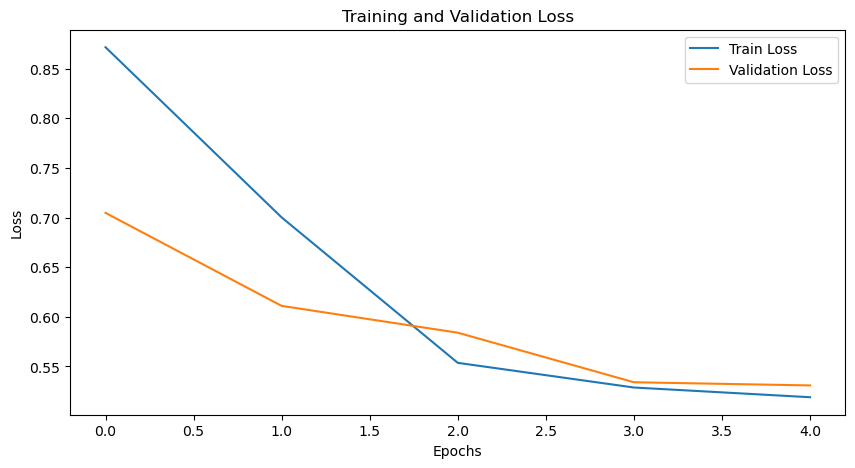

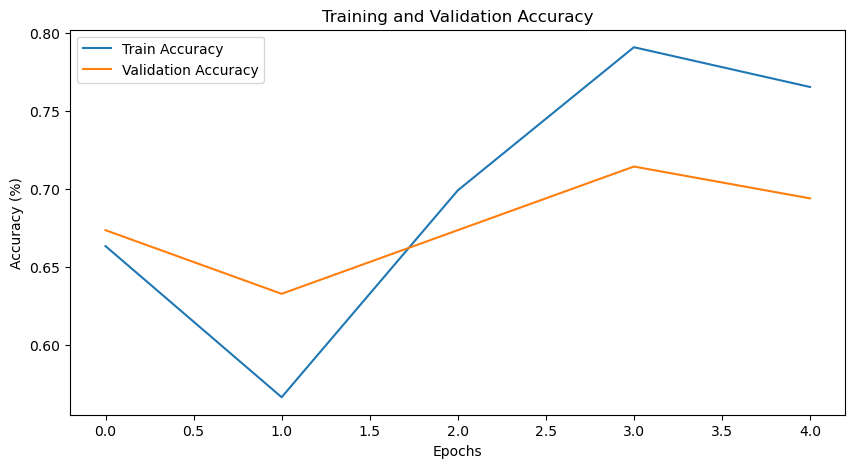

In [12]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()